# Проект по E-commerce — Выявление профилей потребления

## Материалы:

Презентация: <https://drive.google.com/file/d/118nZOY50UDnbSASwVPEpcz8gCTh6hD6b/view?usp=sharing>

Дашборд: 
<https://public.tableau.com/views/Final_ecommerce_project/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link>

## Задача исследования:

Разделить покупателей по профилю потребления для дальнейшего создания персонализированных предложений для покупателей (таргетинга)

## Описание данных

Исследование основано на внутренних данных интернет-магазина товаров для дома и быта «Пока все ещё тут».

Таблица ecommerce включает следующие поля:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

Данные предоставлены в формате csv. 

# Содержание проекта

1. [Загрузка и изучение данных](#start)
2. [Предобработка данных:](#preprocessing)
    - [Предобработка данных: выводы](#preprocessing_end)
3. [Исследовательский анализ данных](#analysis) 
    - [Исследовательский анализ данных: выводы](#analysis_end)
4. [Сегментация пользователей и проверка гипотез](#segmentation)
    - [Сегментация пользователей и проверка гипотез: выводы](#segmentation_end)

# 1. Загрузка и изучение данных<a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal


# <Убираем предупреждения>
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# импортируем данные
from io import BytesIO
import requests
spreadsheet_id = '...'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

df = pd.read_csv(BytesIO(r.content))
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [4]:
df.describe()

,date,order_id,quantity,price
count,6.737000e+03,6737.000000,6737.000000,6737.000000
mean,2.018855e+09,43128.948345,2.501559,462.028499
std,3.855185e+05,27899.414662,15.266478,871.296064
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019020e+09,14827.000000,1.000000,101.000000
50%,2.019050e+09,68503.000000,1.000000,135.000000
75%,2.019061e+09,70504.000000,1.000000,398.000000
max,2.019103e+09,73164.000000,1000.000000,14917.000000


In [5]:
df.corr()

,date,order_id,quantity,price
date,1.000000,-0.349686,-0.024452,-0.087099
order_id,-0.349686,1.000000,0.078812,0.384966
quantity,-0.024452,0.078812,1.000000,-0.032760
price,-0.087099,0.384966,-0.032760,1.000000



# 2. Предобработка данных:<a id="preprocessing"></a>

**Приведение данных к нижнему регистру**

In [6]:
df['product'] = df['product'].str.lower()
df['product']

0         комнатное растение в горшке алое вера, d12, h30
1       комнатное растение в горшке кофе арабика, d12,...
2                             радермахера d-12 см h-20 см
3                        хризолидокарпус лутесценс d-9 см
4                          циперус зумула d-12 см h-25 см
                              ...                        
6732    таз пластмассовый 40,0 л пищевой овальный (иж)...
6733           сумка-тележка 2-х колесная gimi argo синяя
6734    герань домашняя (пеларгония зональная) цветуща...
6735    таз пластмассовый со стиральной доской (иж), 1...
6736           сумка-тележка 2-х колесная gimi argo синяя
Name: product, Length: 6737, dtype: object

**Поиск пропущенных значений**

In [7]:
df.isnull().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Пропущенных значений не обнаружено

**Обработка значений в столбцах с аномалиями**

- Замена типов данных

In [8]:
# Проверяем, что в датасете нет цен с точностью до копеек
df['decimal'] = df['price'] - df['price'].astype('int')
df.decimal.value_counts()

0.0    6737
Name: decimal, dtype: int64

Поскольку десятичная часть цены во всем датасете равна 0, заменяем вещественный тип данных на целочисленный

In [9]:
df = df.drop(columns = ['decimal'])

In [10]:
df['price'] = df['price'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         6737 non-null   int64 
 1   customer_id  6737 non-null   object
 2   order_id     6737 non-null   int64 
 3   product      6737 non-null   object
 4   quantity     6737 non-null   int64 
 5   price        6737 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 315.9+ KB


In [11]:
# Приводим к формату даты с детализацией до часов
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['date']

0      2018-10-01 00:00:00
1      2018-10-01 00:00:00
2      2018-10-01 00:00:00
3      2018-10-01 00:00:00
4      2018-10-01 00:00:00
               ...        
6732   2019-10-31 11:00:00
6733   2019-10-31 12:00:00
6734   2019-10-31 13:00:00
6735   2019-10-31 14:00:00
6736   2019-10-31 16:00:00
Name: date, Length: 6737, dtype: datetime64[ns]

**Добавление столбцов с годом, месяцем и днем покупки**

In [12]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df

,date,customer_id,order_id,product,quantity,price,year,month,day
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,2018,10,1
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,2018,10,1
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,2018,10,1
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,2018,10,1
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,2018,10,1
...,...,...,...,...,...,...,...,...,...
6732,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"таз пластмассовый 40,0 л пищевой овальный (иж)...",1,404,2019,10,31
6733,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,сумка-тележка 2-х колесная gimi argo синяя,1,1087,2019,10,31
6734,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,герань домашняя (пеларгония зональная) цветуща...,1,157,2019,10,31
6735,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"таз пластмассовый со стиральной доской (иж), 1...",1,397,2019,10,31


**Удаление редких и выбивающиеся значений**

In [13]:
# Посмотрим, сколько выбивающихся значений  в столбце quantity
np.percentile(df.quantity, [99, 99.5, 99.9])

array([ 26.64,  50.  , 150.  ])

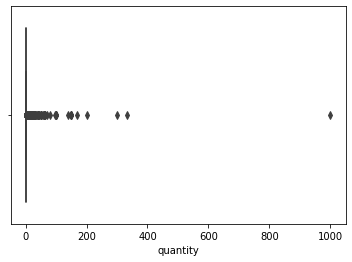

In [14]:
sns.boxplot(df['quantity'], data = df)

Считаем выбросами транзакции с количеством товаров в заказе больше 150

In [15]:
# Удаляем полностью заказы с количеством покупок в одной транзакции больше 150
df_2 = df.query('quantity > 150')
orders_to_keep = df_2['order_id']

df = df.query('order_id not in @orders_to_keep')

**Проверка данных на правило правилу "1 заказ = 1 клиент"**

В реальной жизни не должно случаться такого, чтобы 1 заказ соответствовал сразу нескольким клиентам.

In [16]:
# Делаем группировку по заказам для проверки: есть ли у одного заказа несколько клиентов

orders_groupby_customer_id = df.groupby('order_id').agg({'customer_id': 'count', 'customer_id': 'nunique'}).reset_index()
orders_groupby_customer_id.customer_id.value_counts()

1    2750
2      26
3       2
4       1
Name: customer_id, dtype: int64

In [17]:
# Посмотрим, сколько данных относится к заказам, которые не соответствуют правилу 1 заказ = 1 клиент
np.percentile(orders_groupby_customer_id.customer_id, [98, 98.5, 99])

array([1., 1., 2.])

Заказы, которые не соответствуют правилу 1 заказ = 1 клиент занимают менее 1,5% всех заказов

Посмотрим, сколько места они занимают среди всего датасета

In [18]:
delete_orders = orders_groupby_customer_id.query('customer_id != 1')
delete_orders['order_id'].count()/df['order_id'].count()*100

0.43077837195484253

In [19]:
# удаляем выбросы
df = df.query('order_id not in @delete_orders.order_id')

**Проверка данных на правило правилу "1 заказ = 1 дата"**

В реальной жизни не должно случаться такого, чтобы 1 заказ соответствовал сразу нескольким датам.

In [20]:
# Делаем группировку по заказам для проверки: есть ли у одного заказа несколько дат

orders_groupby_date = df.groupby('order_id').agg({'date': 'count', 'date': 'nunique'}).reset_index()
orders_groupby_date.date.value_counts()

1     2494
2      172
3       47
4       14
5        7
7        4
6        4
9        2
23       1
74       1
60       1
16       1
10       1
8        1
Name: date, dtype: int64

In [21]:
# Посмотрим, сколько данных относится к заказам, которые не соответствуют правилу 1 заказ = 1 клиент
np.percentile(orders_groupby_date.date, [91, 95, 99])

array([2., 2., 4.])

Заказы, которые не соответствуют правилу 1 заказ = 1 дата занимают более 9 % всех заказов, что много, поэтому с этим вопросом следует обратиться к сотруднику, который выгружал данные

Данные в связи с этим не удаляем.

**Поиск и удаление дубликатов**

In [24]:
# Меняем русское ё на е
df['product'] = df['product'].replace(regex= 'ё', value='е')

# <Ищем дубликаты по всем строкам таблицы>
print('Количество дубликатов в таблице df:', 
      df.duplicated(
          subset = df.columns,
          keep = 'first'
      ).sum()
     )

Количество дубликатов в таблице df: 0


### 2.2 Предобработка данных: выводы<a id="preprocessing_end"></a>

1. Привели данные к нижнему регистру
2. Не обнаружили пропущенных значений
3. Заменили вещественный тип данных столбца 'price' на целочисленный
4. Привели столбец 'date' к формату даты с детализацией до часов
5. Добавили столбцы с годом, месяцем и днем транзакции
6. Удалили выбивающиеся значения в столбце 'quantity'
7. Заменили русское ё на е в столбце 'product'
8. Не нашли дубликатов в таблице

# 3. Исследовательский анализ данных<a id="analysis"></a>



**Сколько всего транзакций, заказов, уникальных пользователей?**


In [25]:
print('Количество транзакций:', df['date'].count())
print('Количество заказов:', df['order_id'].nunique())
print('Количество уникальных пользователей:', df['customer_id'].nunique())

Количество транзакций: 6643
Количество заказов: 2750
Количество уникальных пользователей: 2389



**Данными за какой период мы располагаем?**

In [26]:
print('Располагаем данными за период с', df['date'].min(), 'по', df['date'].max())

Располагаем данными за период с 2018-10-01 00:00:00 по 2019-10-31 16:00:00


**Посчитать выручку по каждой транзакции**

In [27]:
# Считаем выручку по каждой транзакции
df['revenue'] = df['quantity'] * df['price']

df.head()

,date,customer_id,order_id,product,quantity,price,year,month,day,revenue
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,2018,10,1,142
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,2018,10,1,194
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,2018,10,1,112
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,2018,10,1,179
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,2018,10,1,112


**Изучить числовые параметры, построить гистограммы для каждого параметра**

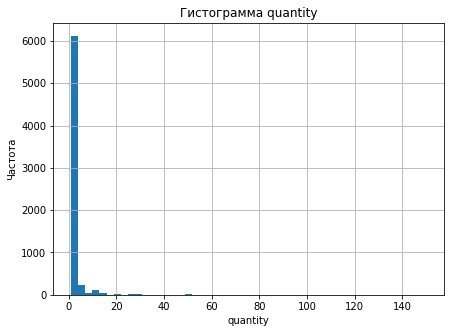

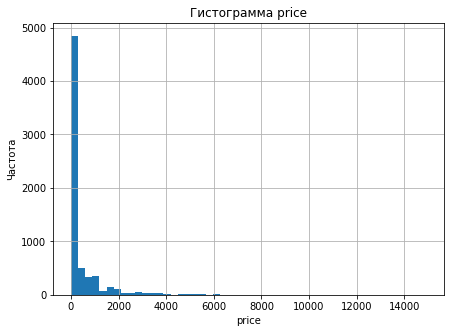

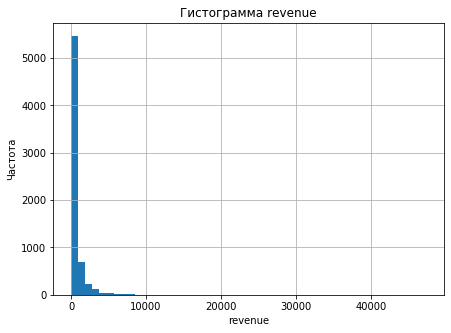

In [28]:
list_of_columns = ['quantity', 'price', 'revenue']
for column in list_of_columns:
    df[column].hist(figsize=(7,5), bins = 50)
    plt.title('Гистограмма {}'.format(column))
    plt.xlabel(column)
    plt.ylabel("Частота")
    plt.show()

Распределения параметров 'quantity', 'price' и 'revenue' не являются нормальными, следственно, для расчета среднего необходимо воспользоваться медианой

**Изучить средние, максимальные и минимальные значения и стандартные отклонения**

In [29]:
df.describe()

,order_id,quantity,price,year,month,day,revenue
count,6643.000000,6643.000000,6643.000000,6643.000000,6643.000000,6643.000000,6643.000000
mean,42813.646997,2.177480,456.760951,2018.788800,6.414572,14.538160,602.649405
std,27900.192241,6.733224,861.917880,0.408191,3.028129,8.745241,1360.708985
min,12624.000000,1.000000,9.000000,2018.000000,1.000000,1.000000,9.000000
25%,14822.000000,1.000000,104.000000,2019.000000,4.000000,7.000000,120.000000
50%,68477.000000,1.000000,135.000000,2019.000000,6.000000,13.000000,157.000000
75%,70463.000000,1.000000,397.000000,2019.000000,9.000000,22.000000,599.000000
max,73164.000000,150.000000,14917.000000,2019.000000,12.000000,31.000000,47385.000000


**quantity:**

- 75% транзакций состоят из одного товара
- С учетом удаления выбросов, наибольшее количество товаров в транзакции - 150

**price:**

- Минимальная цена товара - 9 у.е.
- Максимальная цена товара - 14917 у.е.
- Средняя цена в магазине - 135 у.е.


**revenue:**

- Минимальная выручка - 9 у.е.
- Максимальная выручка - 47385 у.е.
- Средняя выручка - 157 у.е.

**Категоризировать покупки пользователей на основании столбца product: с помощью регулярных выражений**

In [30]:
df['product_1_word'] = df['product'].str.split(' ', expand=True)[0]
df['product_2_word'] = df['product'].str.split(' ', expand=True)[1]
df.head()

,date,customer_id,order_id,product,quantity,price,year,month,day,revenue,product_1_word,product_2_word
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,2018,10,1,142,комнатное,растение
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,2018,10,1,194,комнатное,растение
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,2018,10,1,112,радермахера,d-12
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,2018,10,1,179,хризолидокарпус,лутесценс
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,2018,10,1,112,циперус,зумула


In [31]:
category_dict = {
    'plants': ['комнатное', 'радермахера', 'хризолидокарпус', 'циперус', 'шеффлера', 'юкка',  'многолетнее', 'герань', 
                    'пеларгония', 'суккулент', 'эхеверия', 'эвкалипт', 'цветок', 'адиантум','кампанула', 'калатея', 'нолина', 
                    'хлорофитум', 'цикламен', 'глоксиния', 'азалия', 'гортензия', 'хризантема', 'мирт', 'цветущее', 'кориандр',
                    'иссоп', 'сантолина', 'аспарагус', 'афеляндра', 'антуриум', 'молодило', 'фиалка', 'гербера', 'душица', 
                    'мелисса', 'роза', 'бегония', 'розмарин', 'альбука', 'бальзамин', 'крассула', 'артемизия', 'лаванда', 
                    'мята', 'каланхое', 'примула', 'дендробиум', 'калоцефалус', 'каллуна', 'капсикум', 'мимоза', 'соланум', 
                    'бархатцы', 'космея', 'морковь', 'настурция', 'огурец', 'петуния', 'алиссум', 'гвоздика', 'годеция', 
                    'календула', 'капуста', 'кореопсис', 'лапчатка', 'львиный', 'флокс', 'цинерария', 'эшшольция', 
                    'диффенбахия', 'фаленопсис', 'подсолнечник', 'пуансетия', 'гиностемма','ель', 'кипарисовик', 'аптения', 
                    'пуансеттия', 'скиммия', 'фиттония', 'тимьян', 'алоэ', 'спатифиллум', 'фикус',  'кодонанта', 'цикламен,', 
                    'гимнокалициум','эхинокактус', 'крокусы',  'гипсофила', 'калибрахоа', 'эпипремнум',  'аквилегия', 
                    'базилик', 'горох', 'земляника', 'незабудка', 'седум', 'томат', 'укроп', 'нефролепис', 'калла', 'декабрист',
                    'тюльпан', 'гиацинт', 'вербена', 'однолетнее', 'чабер', 'бакопа', 'ранункулус', 'газания', 'овсянница', 
                    'георгина', 'смолевка', 'цинния', 'лавр', 'вербейник', 'виола', 'колокольчик', 'котовник', 'эхинацея', 
                    'ясколка',  'лилейник', 'папоротник', 'платикодон', 'энотера', 'фуксия', 'цитрофортунелла','пеперомия', 
                    'дыня', 'циния', 'синнингия', 'гардения', 'томата', 'лобелия', 'девичий', 'мускари', 'пиретрум', 
                    'агератум', 'колеус', 'тагетис', 'цинерания', 'муррайя', 'портулак', 'астра', 'аргирантерум', 'левкой', 
                    'вероника', 'целозия', 'арбуз', 'баклажан', 'клубника', 'патиссон', 'маттиола', 'сальвия', 'лук', 'джункус', 
                    'драцена', 'фатсия', 'хоста', 'гайлардия', 'монарда', 'нивянник', 'рудбекия', 'барвинок',  'осина', 
                    'сциндапсус', 'бузульник', 'солидаго','физостегия', 'бадан', 'лен', 'лантана',  'лаватера', 'анемона', 
                    'буддлея', 'валериана', 'змееголовник', 'любисток','петрушка', 'сельдерей', 'шалфей',  'вигна','кабачок', 
                    'тыква', 'хамедорея', 'зверобой', 'мединилла', 'импатиенс', 'клен',  'замиокулькас', 'амариллис', 'салат', 
                    'пахира','литопс', 'рассада', 'подарочный', 'подвесное', 'муляж', 'искусственный', 'декоративная', 
                    'искусственная', 'новогоднее', 'кофе', 'табак'],
    
    'kitchen': ['мини-сковорода', 'сковорода', 'стеклянная', 'тарелка', 'вилка', 'ложка', 'нож', 'скатерть', 
                'кувшин', 'толкушка', 'готовая', 'чайник', 'противень', 'вкладыши', 'миксер', 'салфетка', 'tepмокружка',
                'ножеточка', 'масленка', 'сервировочная', 'салатник', 'чайный', 'рыбочистка', 'овощеварка', 'терка', 
                'кружка', 'лопатка', 'салфетница', 'стакан', 'столовая', 'чайная', 'овощечистка', 'пробка', 'измельчитель', 
                'губка',  'мантоварка', 'кухонные', 'картофелемялка', 'миска', 'кисточка',
                'ковш', 'термостакан', 'термокружка', 'термос', 'фарфоровая', 'электроштопор', 'столовый', 
                'блюдце',  'бульонница',  'разделочная', 'мантоварка-пароварка', 'просеиватель', 'кастрюля', 'хлебница', 
                'форма', 'орехоколка', 'кухонное', 'пряные', 'антинакипин',  'сотейник', 'крышка', 'сахарница',
                'соковарка', 'пьезозажигалка', 'соковыжималка', 'половник', 'кипятильник', 'мерный', 'скалка', 'венчик', 
                'сито', 'тортница', 'блюдо', 'защитный', 'защитная', 'нетканые', 'шприц', 'универсальный', 'основание',
                'концентрат', 'пресс', 'банка', 'контейнер', 'лоток', 'жестяная', 'бидон', 'корзинка', 'мешок'],
    
    'household': ['настенная', 'чехол',  'сушилка', 'крючок', 'доска', 'сумка-тележка', 'щетка-сметка', 'котел', 
            'коврик', 'подкладка', 'плед', 'ковер',  'гладильная',  'тележка',
            'простыня', 'штора', 'плечики', 'подушка',  'петля',
            'щетка-утюжок',  'подрукавник',  'насадка', 'наматрасник', 'наматрицник-чехол', 'настольная',
            'утюг',  'термометр', 'покрывало', 'весы', 
            'одеяло',  'простынь',  'сметка',
            'фоторамка', 'пылесос', 'наволочка', 'пододеяльник',  'ваза', 'прищепки',
            'двуспальное', 'полка', 'окномойка', 'урна-пепельница', 'наматрацник','кольца', 'складной', 'завертка',
            'решетка', 'вакуумный', 'рукав', 'доска', 'сумка', 'кофр',  'ящик', 'ведро', 'короб', 'коробка', 'корыто',
            'складная', 'емкость', 'модульная', 'бак'],
    
    'construction': ['стремянка', 'лестница-стремянка', 'стяжка', 'крепеж', 'пружина', 'стремянки', 'сверло-фреза,', 'холодная',
                    'шнур', 'измерительный', 'линейка', 'бензин', 'паста', 'петля-стрела', 'держатель', 'ролик', 'шило', 
                    'скребок', 'рассекатель', 'сетка', 'ручка-скоба', 'стремянка-табурет', 'насадка-отжим',
                    'камнеломка', 'шпагат', 'отделитель', 'покрытие', 'веревка', 'уголок', 'стяжки', 'шпингалет',
                    'штангенциркуль','насадка-моп', 'сверло', 'сменный', 'многофункциональный', 'фал', 'фиксатор-шар'],
    
    'bathroom': ['ерш', 'дозатор',  'полотенце',  'жидкое', 'пена', 'зубная',
                 'мыло', 'фен', 'ароматизированное', 'бальзам', 'ополаскиватель', 'мыльница',  'ванна', 
                 'отбеливатель', 'махровый', 'мыло-скраб', 'бельевые', 'карниз',   'халат', 'подголовник',
                 'сиденье', 'универсальное', 'кондиционер', 'гипоаллергенный', 'махровое',  'штанга', 'отжим', 
                 'запасная', 'увлажняющая', 'корзина'],
    
    'furniture': ['ручка', 'вешалка', 'светильник', 'вешалка-плечики', 'вешалка-стойка', 'вешалки', 'комод', 
               'вешалка-сушилка', 'этажерка', 'полки', 'ключница', 'вешалка-перекладина', 'лестница', 'обувница-3',
               'стеллаж', 'подставка'],
    
    'cleaning': ['мусорный', 'урна', 'антижир', 'тряпка', 'сменная', 'ткань', 'автоматическая', 'тряпкодержатель',
               'перчатки', 'стиральный', 'чистящий', 'вантуз', 'веник', 'швабра', 'совок', 'щетка', 'средство','таз'],
    'sets': ['набор', 'комплект']}


In [32]:
# Создаем функцию для определения категории товара
def category(df):
    product = df['product']
    product1 = df['product_1_word']
    product2 = df['product_2_word']
    
    for category, items in category_dict.items():
        for item in items:
            if item in product1:
                if category == 'sets':
                    if product2 in ['прищепок', 'ковров', 'постельного']:
                        return 'household'
                    if product2 in ['вешалок',]:
                        return 'furniture'
                    if product2 in ['сверел', 'vileda', 'инструментов', 'прецизионных']:
                        return 'construction'
                    if product2 in ['кружек', 'фужеров', 'эмалированных', 'кухонных',
                                    'бокалов', 'стаканов', 'ножей','форм', 'столовых','посуды']:
                        return 'kitchen'
                    if product2 in ['махровых']:
                        return 'bathroom'
                    else:
                        if 'набор для пикника' in product:
                            return 'kitchen'
                        if 'комплект для ванной' in product:
                            return 'bathroom'
                        if 'комплект для мытья' in product:
                            return 'cleaning'
                        
                else:
                    return category           
    return category

df['category'] = df.apply(category, axis=1)
df.head()

,date,customer_id,order_id,product,quantity,price,year,month,day,revenue,product_1_word,product_2_word,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,2018,10,1,142,комнатное,растение,plants
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,2018,10,1,194,комнатное,растение,plants
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,2018,10,1,112,радермахера,d-12,plants
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,2018,10,1,179,хризолидокарпус,лутесценс,plants
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,2018,10,1,112,циперус,зумула,plants


In [33]:
df = df.drop(columns = ['product_1_word', 'product_2_word'])
df.head()

,date,customer_id,order_id,product,quantity,price,year,month,day,revenue,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,2018,10,1,142,plants
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,2018,10,1,194,plants
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,2018,10,1,112,plants
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,2018,10,1,179,plants
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,2018,10,1,112,plants


С помощью регулярных выражений составили 7 категорий товаров: 
- 'plants' - растения, 
- 'kitchen' - товары для кухни, 
- 'household' - товары для дома, 
- 'construction' - товары для строительства и ремонта,  
- 'bathroom' - товары для ванной,
- 'furniture' - мебель,
- 'cleaning' - товары для уборки

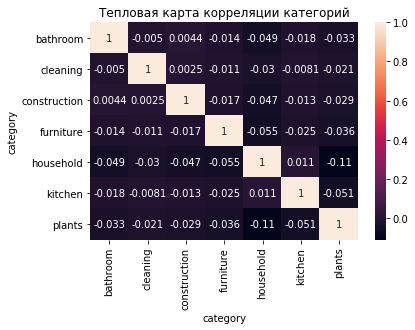

In [34]:
# Составим сводную таблицу для проверки, не коррелируют ли выделенные категории между собой 
category_pivot = df.pivot_table(index='customer_id', columns='category', values='revenue')
category_pivot = category_pivot.fillna(0)

#Создаем тепловую карту
category_corr_heatmap = category_pivot.corr()
sns.heatmap(category_corr_heatmap, annot = True)
plt.title('Тепловая карта корреляции категорий')
plt.show()

Среди категорий нет корреляций больше 0.11, можно считать деление на категории правильным

**Добавить столбцы по каждой категории**

In [35]:
df = df.join(pd.get_dummies(df.category))
df

,date,customer_id,order_id,product,quantity,price,year,month,day,revenue,category,bathroom,cleaning,construction,furniture,household,kitchen,plants
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,2018,10,1,142,plants,0,0,0,0,0,0,1
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,2018,10,1,194,plants,0,0,0,0,0,0,1
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,2018,10,1,112,plants,0,0,0,0,0,0,1
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,2018,10,1,179,plants,0,0,0,0,0,0,1
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,2018,10,1,112,plants,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"таз пластмассовый 40,0 л пищевой овальный (иж)...",1,404,2019,10,31,404,cleaning,0,1,0,0,0,0,0
6733,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,сумка-тележка 2-х колесная gimi argo синяя,1,1087,2019,10,31,1087,household,0,0,0,0,1,0,0
6734,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,герань домашняя (пеларгония зональная) цветуща...,1,157,2019,10,31,157,plants,0,0,0,0,0,0,1
6735,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"таз пластмассовый со стиральной доской (иж), 1...",1,397,2019,10,31,397,cleaning,0,1,0,0,0,0,0


## 3.1 Исследовательский анализ данных: выводы<a id="analysis_end"></a>

1. Количество транзакций: 6643
2. Количество заказов: 2750
3. Количество уникальных пользователей: 2389
4. Располагаем данными за период с 2018-10-01 00:00:00 по 2019-10-31 16:00:00
6. 75% транзакций состоят из одного товара
7. Наибольшее количество товаров в транзакции - 150 (с учетом удаления выбросов)
8. Минимальная цена товара - 9 у.е.
9. Максимальная цена товара - 14917 у.е.
10. Средняя цена в магазине - 135 у.е.
11. Большинство заказов приходится на 2019 год
12. Минимальная выручка - 9 у.е. на транзакцию
13. Максимальная выручка - 47385 у.е. на транзакцию
14. Средняя выручка - 157 у.е. на транзакцию
15. Выделили 7 категорий товаров: 
    - 'plants' - растения, 
    - 'kitchen' - товары для кухни, 
    - 'household' - товары для дома, 
    - 'construction' - товары для строительства и ремонта,  
    - 'bathroom' - товары для ванной,
    - 'furniture' - мебель,
    - 'cleaning' - товары для уборки

# 4. Сегментация пользователей и проверка гипотез<a id="segmentation"></a>

In [36]:
# Создаем столбцы avg_price_per_category, revenue_per_category и favorite_category, и присоединяем их к df
df_category = df.groupby(['customer_id', 'category']).agg({'price': 'mean', 'revenue':'sum'}).reset_index()

df_category = df_category.rename(columns={'price': 'avg_price_per_category', 'revenue':'revenue_per_category'})

df_category_count = df_category.groupby('customer_id').agg({'category': 'max'}).reset_index()
df_category_count = df_category_count.rename(columns={'category': 'favorite_category'})

df = df.merge(df_category[['customer_id', 'avg_price_per_category', 'revenue_per_category']], how = 'left', on='customer_id')
df = df.merge(df_category_count[['customer_id', 'favorite_category']], how = 'left', on='customer_id')


def favorite_category(row):
    if row['favorite_category'] == 'plants':
        return 1
    if row['favorite_category'] == 'household':
        return 2
    if row['favorite_category'] == 'kitchen':
        return 3
    if row['favorite_category'] == 'cleaning':
        return 4
    if row['favorite_category'] == 'bathroom':
        return 5
    if row['favorite_category'] == 'construction':
        return 6
    if row['favorite_category'] == 'furniture':
        return 7

df['favorite_category_numeric'] = df.apply(favorite_category, axis = 1)
df.head()

,date,customer_id,order_id,product,quantity,price,year,month,day,revenue,...,cleaning,construction,furniture,household,kitchen,plants,avg_price_per_category,revenue_per_category,favorite_category,favorite_category_numeric
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,2018,10,1,142,...,0,0,0,0,0,1,148.142857,1037,plants,1
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,2018,10,1,194,...,0,0,0,0,0,1,148.142857,1037,plants,1
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,2018,10,1,112,...,0,0,0,0,0,1,148.142857,1037,plants,1
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,2018,10,1,179,...,0,0,0,0,0,1,148.142857,1037,plants,1
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,2018,10,1,112,...,0,0,0,0,0,1,148.142857,1037,plants,1


С учетом того, что необходимо провести сегментацию пользователей, создадим новый датафрейм, сгруппированный по уникальным пользователям

In [37]:
df_customer_id = df.groupby(['customer_id']).agg(
    {'date': 'max',
     'product': 'count',
     'quantity': 'sum', 
     'price': 'mean',
     'year': 'median',
     'month': 'median',
     'revenue': 'sum',
     'favorite_category_numeric': 'first', 
     'avg_price_per_category': 'mean',
     'revenue_per_category': 'sum'
     }).reset_index()

df_customer_id.columns =  ['customer_id',
                           'max_purchase_date',
                           'product_quantity',
                           'total_quantity', 
                           'avg_price',
                           'year',
                           'month',
                           'revenue_per_customer',
                           'favorite_category_numeric', 
                           'avg_price_per_category',
                           'revenue_per_category'
                          ]

df_customer_id['recency'] = (df_customer_id['max_purchase_date'].max() - df_customer_id['max_purchase_date']).dt.days
df_customer_id = df_customer_id.drop(columns = ['max_purchase_date'])

df_customer_id.head()

,customer_id,product_quantity,total_quantity,avg_price,year,month,revenue_per_customer,favorite_category_numeric,avg_price_per_category,revenue_per_category,recency
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4,4,138.75,2019.0,10.0,555,1,138.75,2220,15
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,442.00,2019.0,2.0,442,2,442.00,442,257
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2,457.00,2019.0,10.0,914,4,457.00,914,16
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1649.00,2019.0,1.0,1649,2,1649.00,1649,276
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2,1162.00,2019.0,9.0,2324,7,1162.00,2324,31


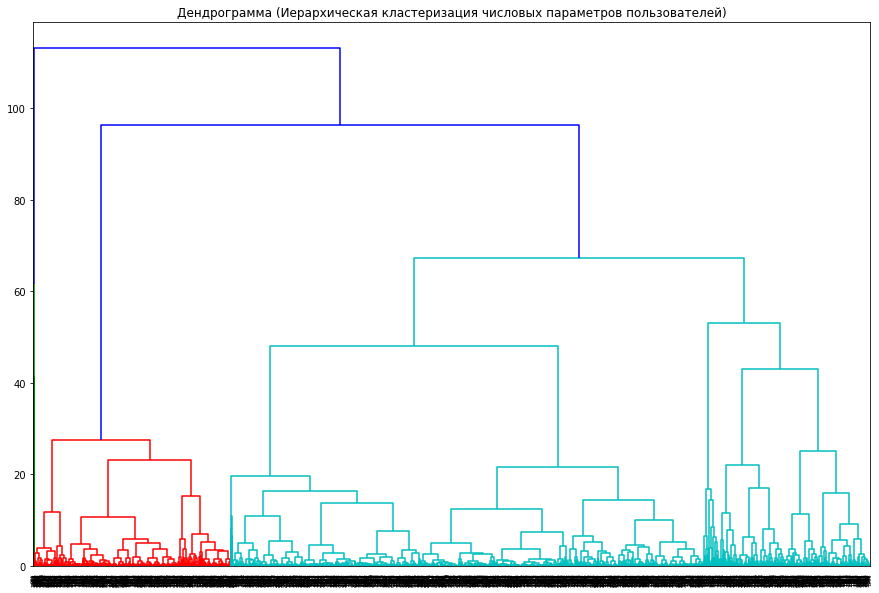

In [38]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler()

# обучаем нормализатор и преобразуем набор данных
X = df_customer_id.drop(['customer_id'], axis = 1)
X_sc_customer_id = scaler.fit_transform(X)

# Строим матрицу расстояний функцией linkage() 
linked = linkage(X_sc_customer_id, method = 'ward')

# Рисуем дендрограмму, чтобы определить количество кластеров для алгоритма K-Means 
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Дендрограмма (Иерархическая кластеризация числовых параметров пользователей)')
plt.show()

In [39]:
# задаём число кластеров, равное 2(по количеству цветов на дендрограмме)
km = KMeans(n_clusters = 2, random_state = 0) 

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc_customer_id) 

# сохраняем метки кластера в поле нашего датасета
df_customer_id['cluster'] = labels

df_customer_id.head()

,customer_id,product_quantity,total_quantity,avg_price,year,month,revenue_per_customer,favorite_category_numeric,avg_price_per_category,revenue_per_category,recency,cluster
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4,4,138.75,2019.0,10.0,555,1,138.75,2220,15,0
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,442.00,2019.0,2.0,442,2,442.00,442,257,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2,457.00,2019.0,10.0,914,4,457.00,914,16,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1649.00,2019.0,1.0,1649,2,1649.00,1649,276,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2,1162.00,2019.0,9.0,2324,7,1162.00,2324,31,0


In [40]:
def st_analysis(df1, df2, title):
    
    plt.figure(figsize=(20, 8))
    plt.title(title)
    plt.ylabel('Частота')
    sns.distplot(df1, kde = False, bins = 30)
    sns.distplot(df2, kde = False, bins = 30)
    plt.show()
    
    alpha = 0.05
    stat, p = shapiro(df1)
    if p > alpha:
        print('df1 имеет распределение Гаусса')
    else:
        print('df1 не имеет распределения Гаусса')
    
    stat, p = shapiro(df2)
    if p > alpha:
        print('df2 имеет распределение Гаусса')
    else:
        print('df2 не имеет распределения Гаусса')
        
    results = stat, p = mannwhitneyu(df1, df2)
    print('p-значение:', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

**Составить гипотезы по полученным кластерам**

Выбрали для тестирования гипотез статистический U-критерий Манна — Уитни, который позволяет отказаться от предположения нормальности распределения и одинаковых дисперсий

product_quantity кластеров 0 и 1 одинаков(а)
Гипотеза H₀: "product_quantity одной генеральной совокупности равен(на) product_quantity другой генеральной совокупности
Гипотеза H₁: "product_quantity одной генеральной совокупности НЕ равен(на) product_quantity другой генеральной совокупности



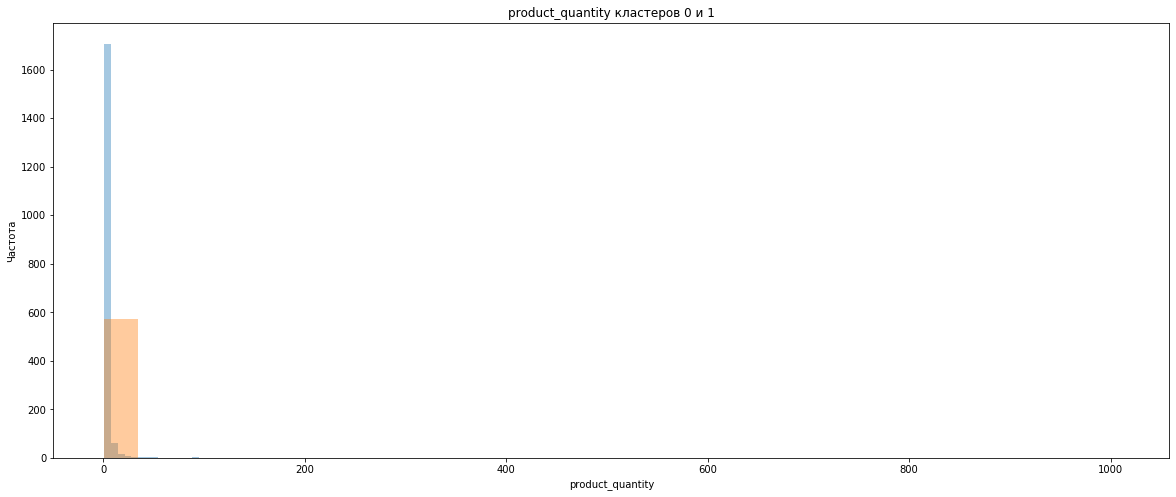

df1 не имеет распределения Гаусса
df2 не имеет распределения Гаусса
p-значение: 0.014336815855667016
Отвергаем нулевую гипотезу

total_quantity кластеров 0 и 1 одинаков(а)
Гипотеза H₀: "total_quantity одной генеральной совокупности равен(на) total_quantity другой генеральной совокупности
Гипотеза H₁: "total_quantity одной генеральной совокупности НЕ равен(на) total_quantity другой генеральной совокупности



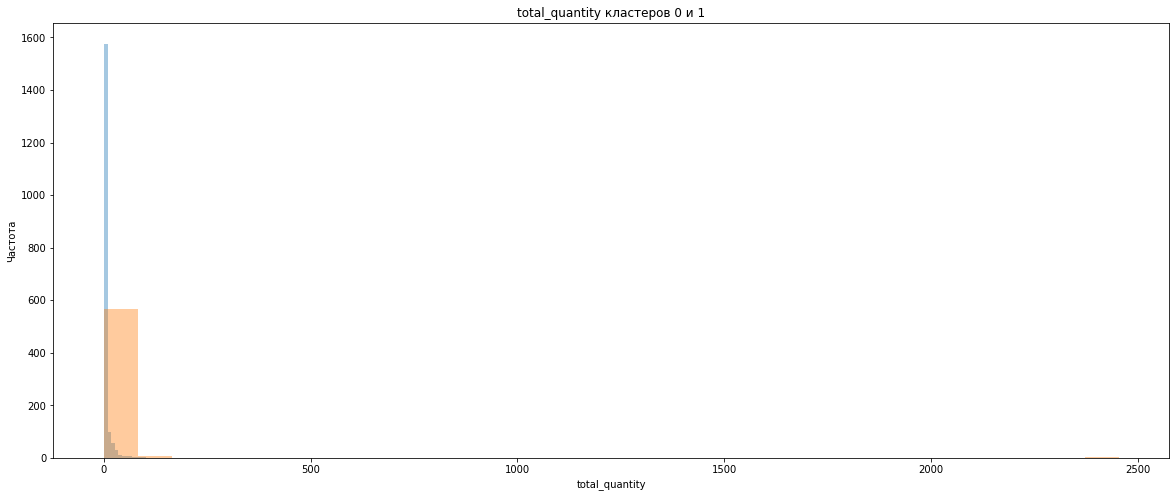

df1 не имеет распределения Гаусса
df2 не имеет распределения Гаусса
p-значение: 0.17173272726809313
Не получилось отвергнуть нулевую гипотезу

avg_price кластеров 0 и 1 одинаков(а)
Гипотеза H₀: "avg_price одной генеральной совокупности равен(на) avg_price другой генеральной совокупности
Гипотеза H₁: "avg_price одной генеральной совокупности НЕ равен(на) avg_price другой генеральной совокупности



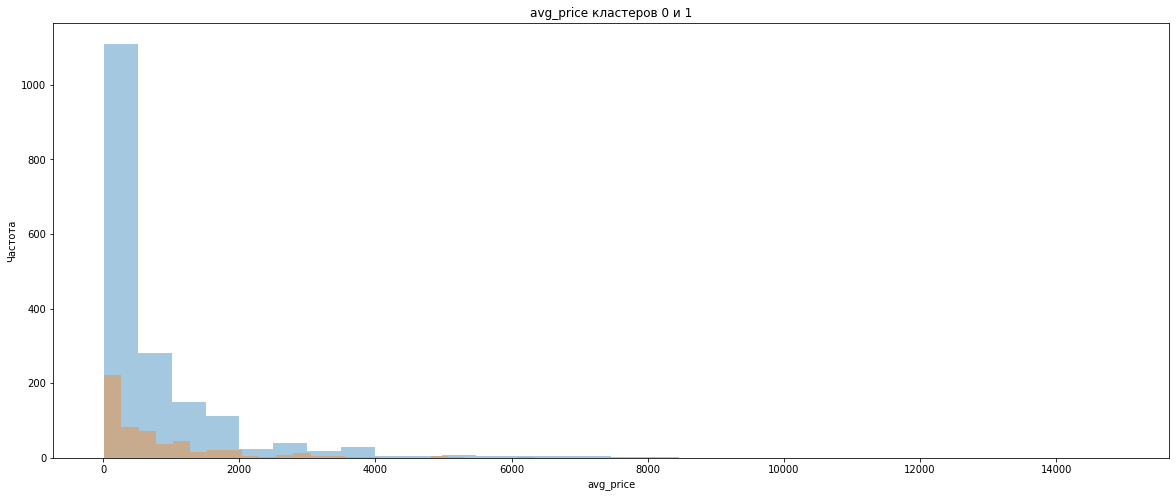

df1 не имеет распределения Гаусса
df2 не имеет распределения Гаусса
p-значение: 1.6539876769998148e-06
Отвергаем нулевую гипотезу

year кластеров 0 и 1 одинаков(а)
Гипотеза H₀: "year одной генеральной совокупности равен(на) year другой генеральной совокупности
Гипотеза H₁: "year одной генеральной совокупности НЕ равен(на) year другой генеральной совокупности



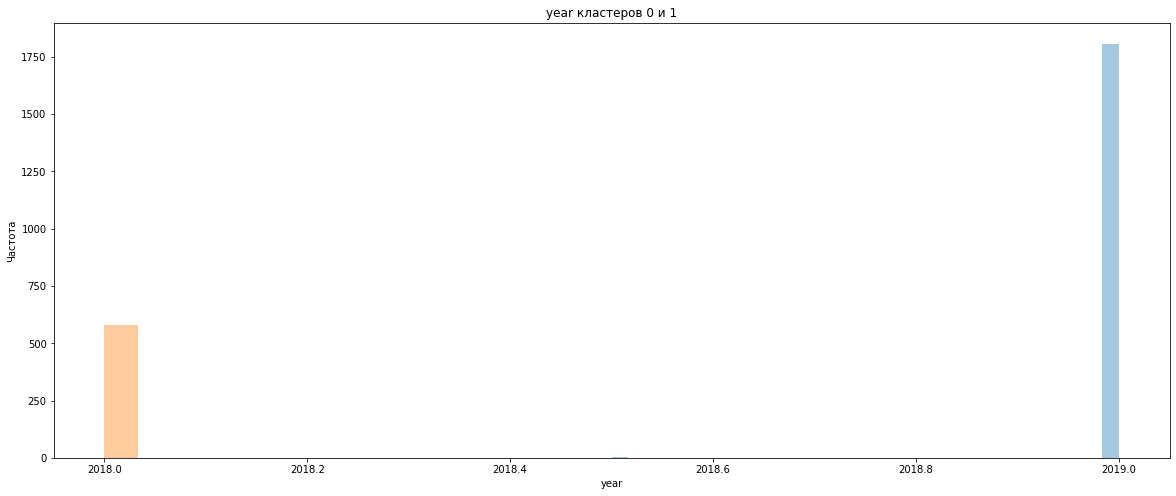

df1 не имеет распределения Гаусса
df2 не имеет распределения Гаусса
p-значение: 0.0
Отвергаем нулевую гипотезу

month кластеров 0 и 1 одинаков(а)
Гипотеза H₀: "month одной генеральной совокупности равен(на) month другой генеральной совокупности
Гипотеза H₁: "month одной генеральной совокупности НЕ равен(на) month другой генеральной совокупности



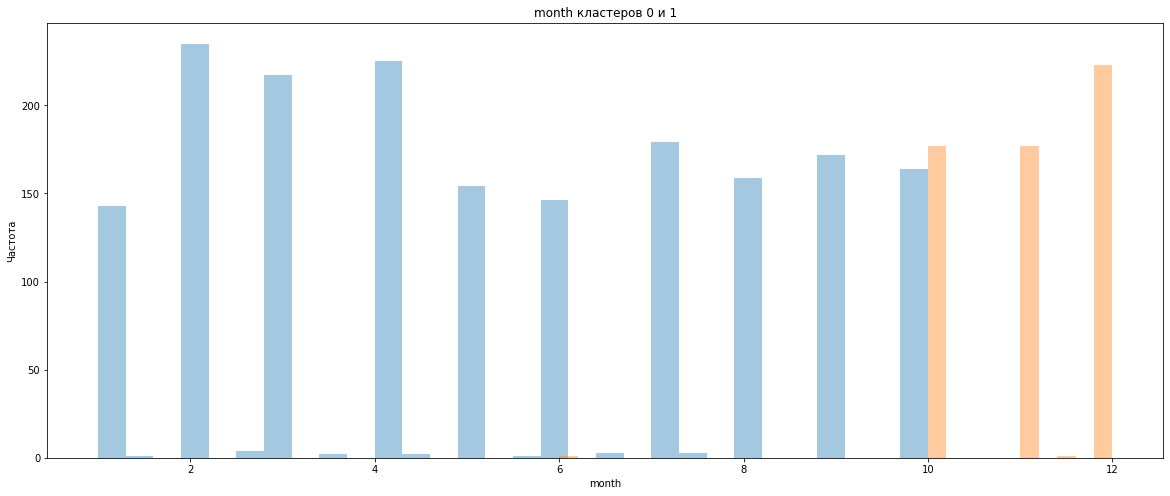

df1 не имеет распределения Гаусса
df2 не имеет распределения Гаусса
p-значение: 3.201459243348715e-274
Отвергаем нулевую гипотезу

revenue_per_customer кластеров 0 и 1 одинаков(а)
Гипотеза H₀: "revenue_per_customer одной генеральной совокупности равен(на) revenue_per_customer другой генеральной совокупности
Гипотеза H₁: "revenue_per_customer одной генеральной совокупности НЕ равен(на) revenue_per_customer другой генеральной совокупности



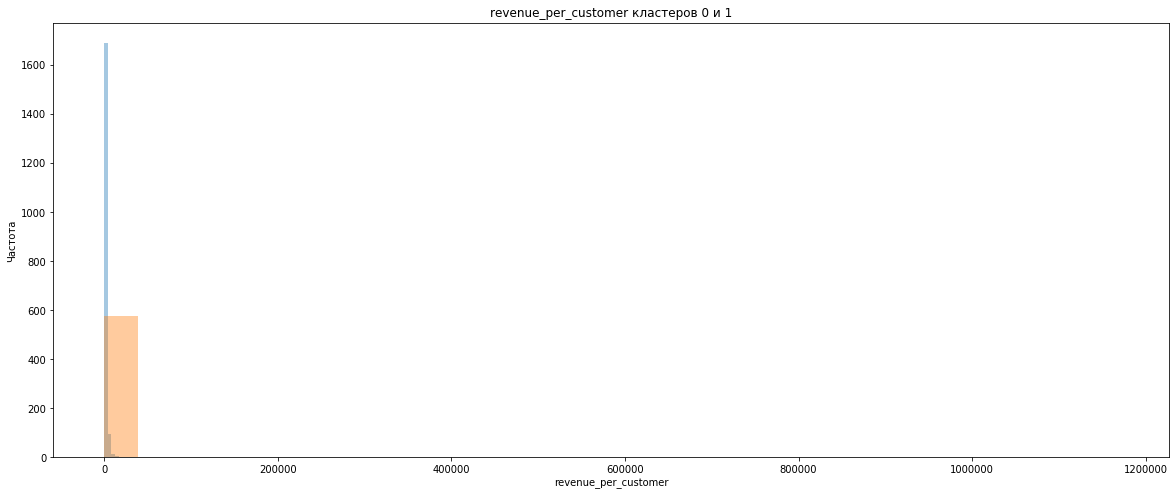

df1 не имеет распределения Гаусса
df2 не имеет распределения Гаусса
p-значение: 2.937548366590342e-08
Отвергаем нулевую гипотезу

revenue_per_category кластеров 0 и 1 одинаков(а)
Гипотеза H₀: "revenue_per_category одной генеральной совокупности равен(на) revenue_per_category другой генеральной совокупности
Гипотеза H₁: "revenue_per_category одной генеральной совокупности НЕ равен(на) revenue_per_category другой генеральной совокупности



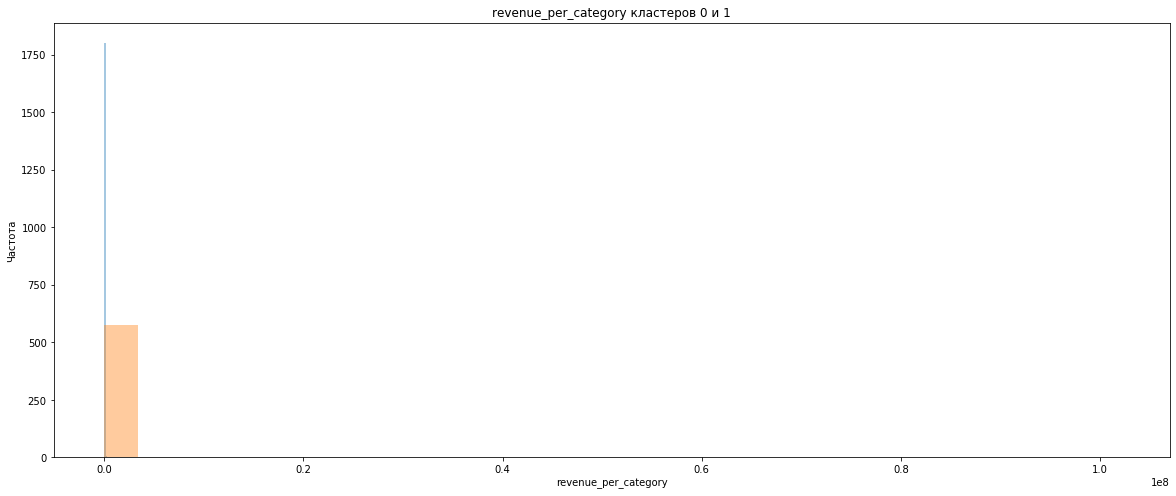

df1 не имеет распределения Гаусса
df2 не имеет распределения Гаусса
p-значение: 1.6246088832362259e-06
Отвергаем нулевую гипотезу

recency кластеров 0 и 1 одинаков(а)
Гипотеза H₀: "recency одной генеральной совокупности равен(на) recency другой генеральной совокупности
Гипотеза H₁: "recency одной генеральной совокупности НЕ равен(на) recency другой генеральной совокупности



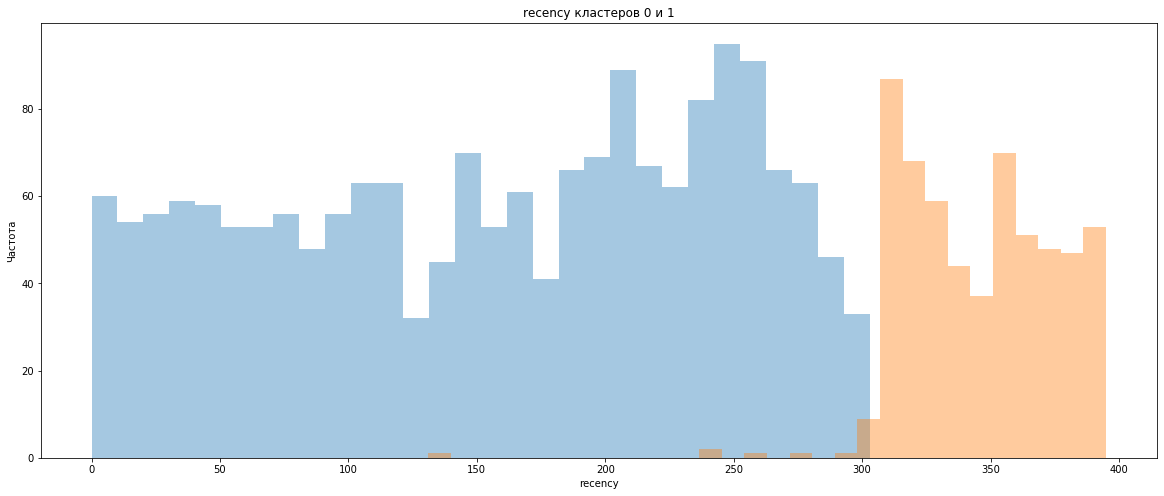

df1 не имеет распределения Гаусса
df2 не имеет распределения Гаусса
p-значение: 8.693261247634484e-286
Отвергаем нулевую гипотезу



In [41]:
# С помошью статистического теста mannwhitneyu смотрим, как распределились кластеры по основным признакам
k = 0
j = 1
for i in df_customer_id[['product_quantity', 'total_quantity', 'avg_price', 'year',
                         'month', 'revenue_per_customer',
                         'revenue_per_category', 'recency']]:
    print('{} кластеров {} и {} одинаков(а)'.format(i,k,j))
    print('Гипотеза H₀: "{} одной генеральной совокупности равен(на) {} другой генеральной совокупности'.format(i, i))
    print('Гипотеза H₁: "{} одной генеральной совокупности НЕ равен(на) {} другой генеральной совокупности'.format(i, i))
    print()    
    st_analysis(df_customer_id.query('cluster == @k')[i], 
                    df_customer_id.query('cluster == @j')[i], 
                    '{} кластеров {} и {}'.format(i, k, j))
    print()

Поскольку большинство нулевых гипотез (7 8) было отвергнуто, в дальнейшем предполагаем, разница между полученными  кластерами статистически значима, и мы можем сегментировать клиентов на основе выделенных кластеров

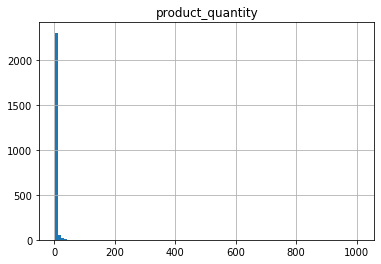

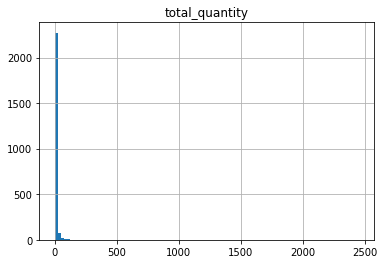

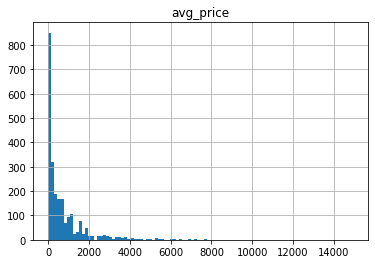

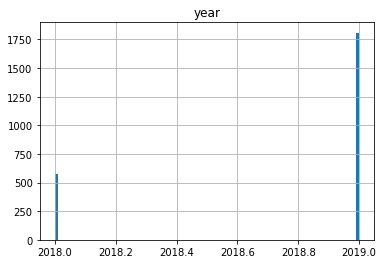

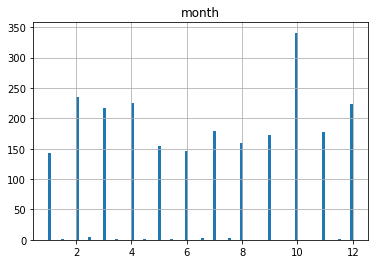

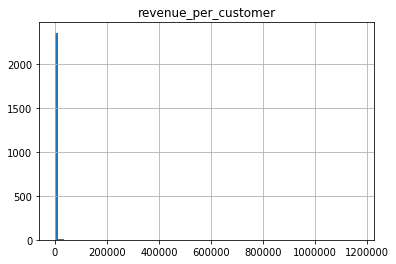

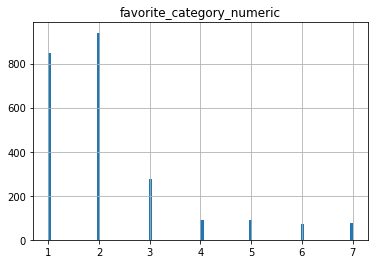

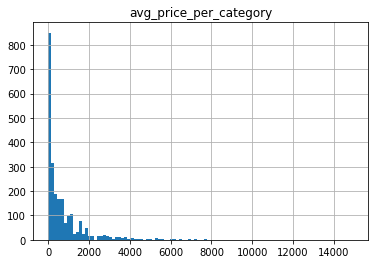

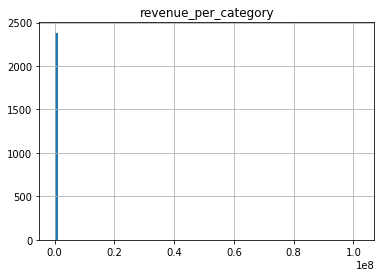

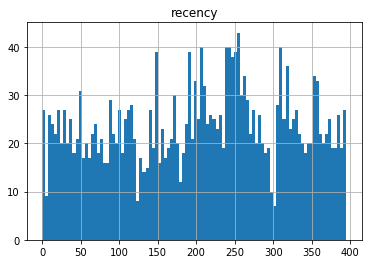

In [42]:
columns = df_customer_id[['product_quantity', 'total_quantity', 'avg_price', 'year', 'month', 'revenue_per_customer', 
                          'favorite_category_numeric','avg_price_per_category', 'revenue_per_category', 'recency']]
for i in columns:
    df_customer_id[i].hist(bins = 100)
    plt.title(i)
    plt.show()

**Посмотрим на средние значения признаков для кластеров, построим распределения признаков для кластеров**

In [43]:
df_customer_id.groupby(['cluster']).mean().round(3).T

cluster,0,1
product_quantity,2.487,6.718
total_quantity,5.350,17.238
avg_price,755.660,855.172
year,2018.999,2018.002
month,5.303,11.072
revenue_per_customer,1585.004,4993.668
favorite_category_numeric,2.196,2.307
avg_price_per_category,755.378,856.833
revenue_per_category,10039.606,231432.786
recency,157.722,345.706


In [44]:
df_customer_id.groupby(['cluster']).median().round(3).T

cluster,0,1
product_quantity,1.0,1.0
total_quantity,1.0,1.0
avg_price,299.0,449.0
year,2019.0,2018.0
month,5.0,11.0
revenue_per_customer,727.0,974.0
favorite_category_numeric,2.0,2.0
avg_price_per_category,299.0,449.0
revenue_per_category,871.0,1162.0
recency,167.0,346.0


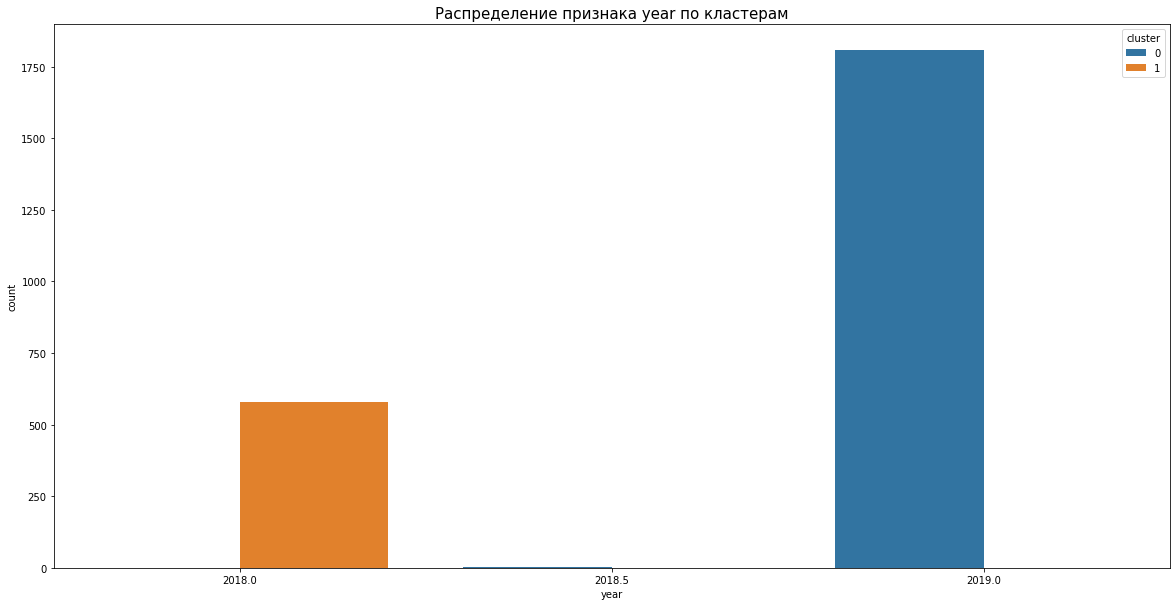

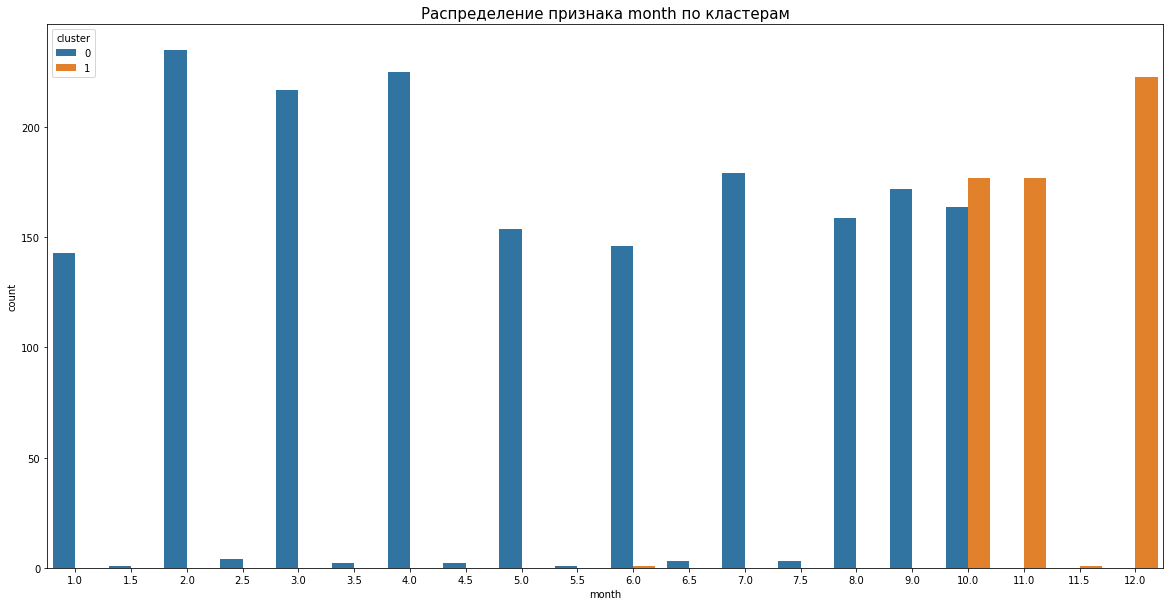

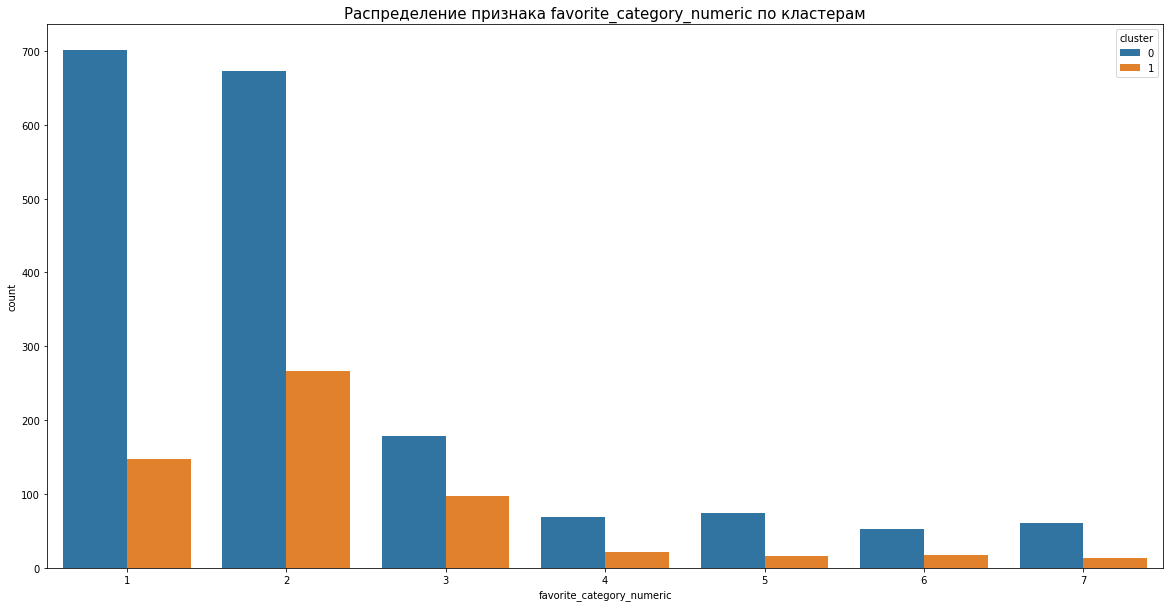

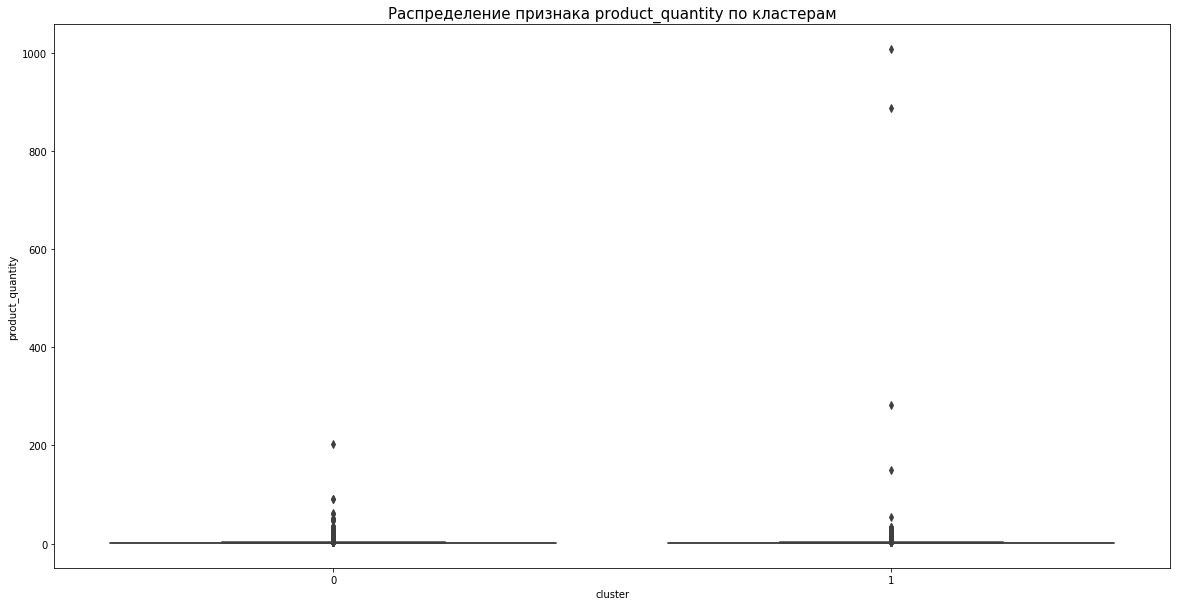

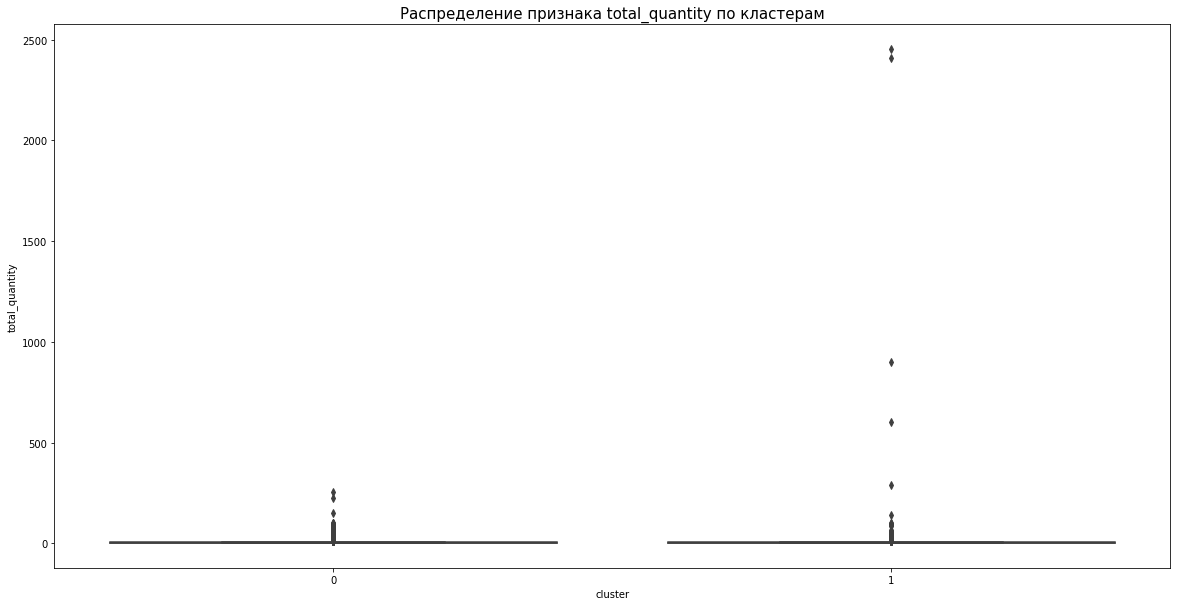

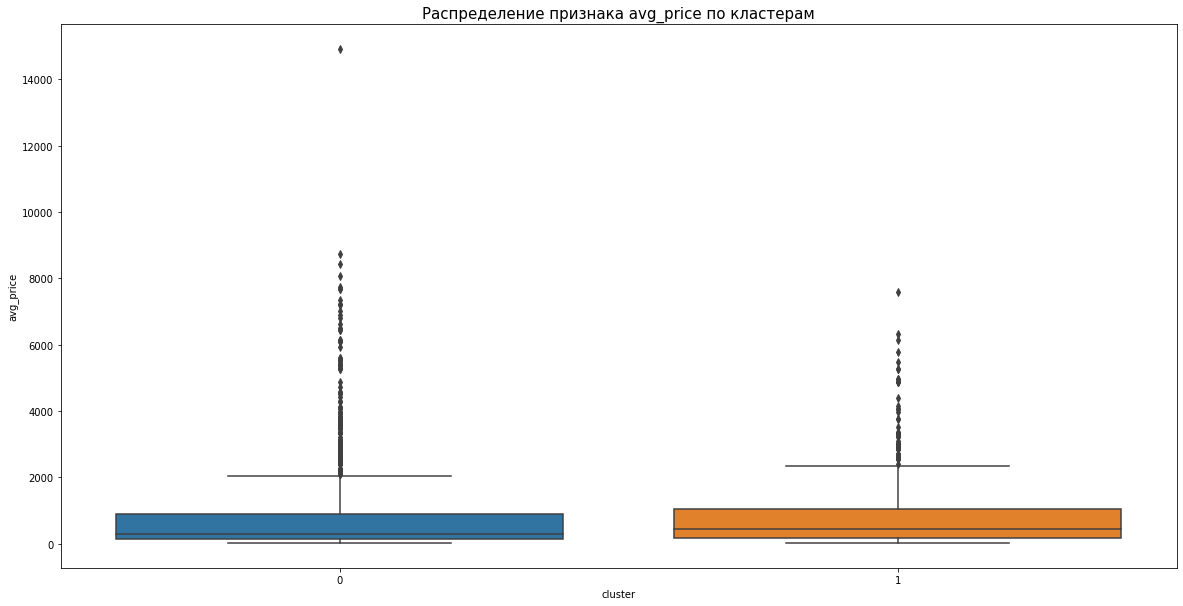

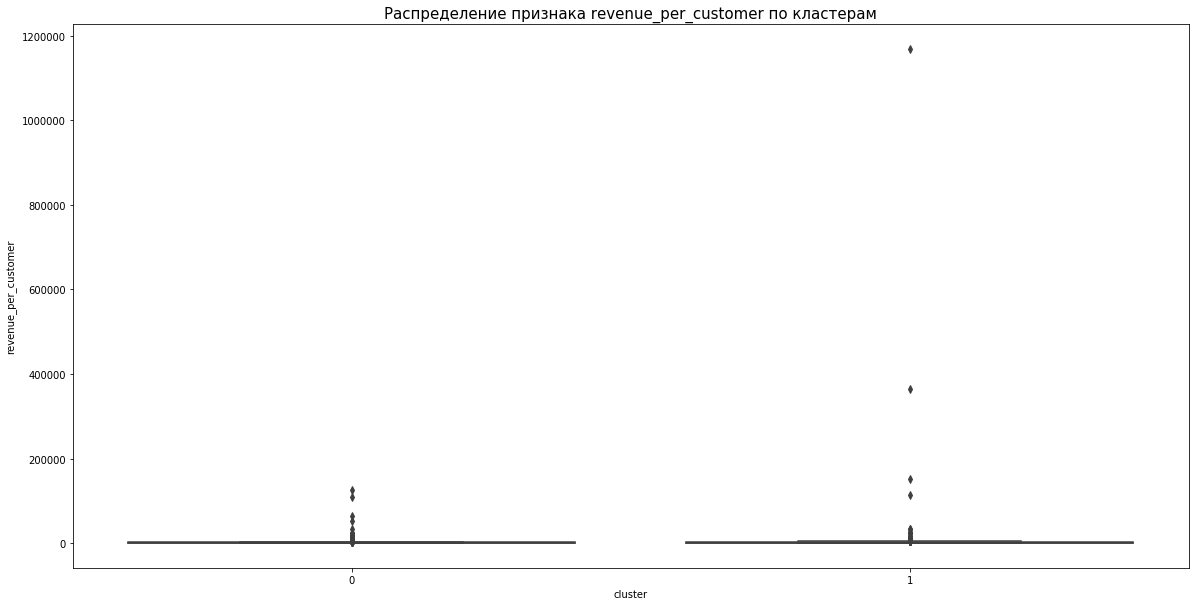

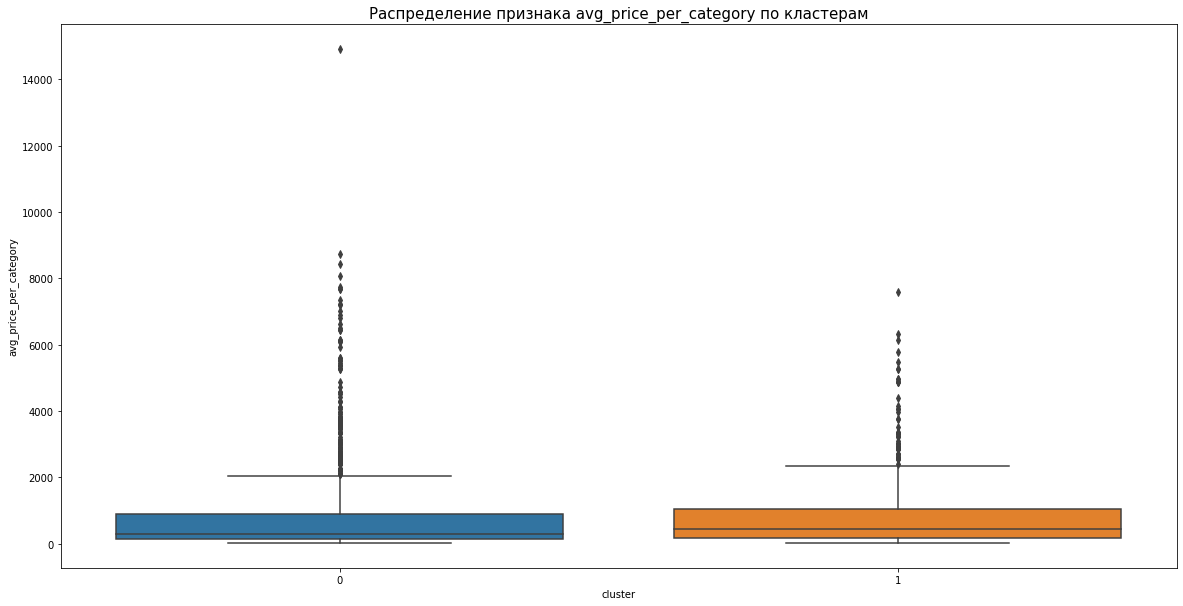

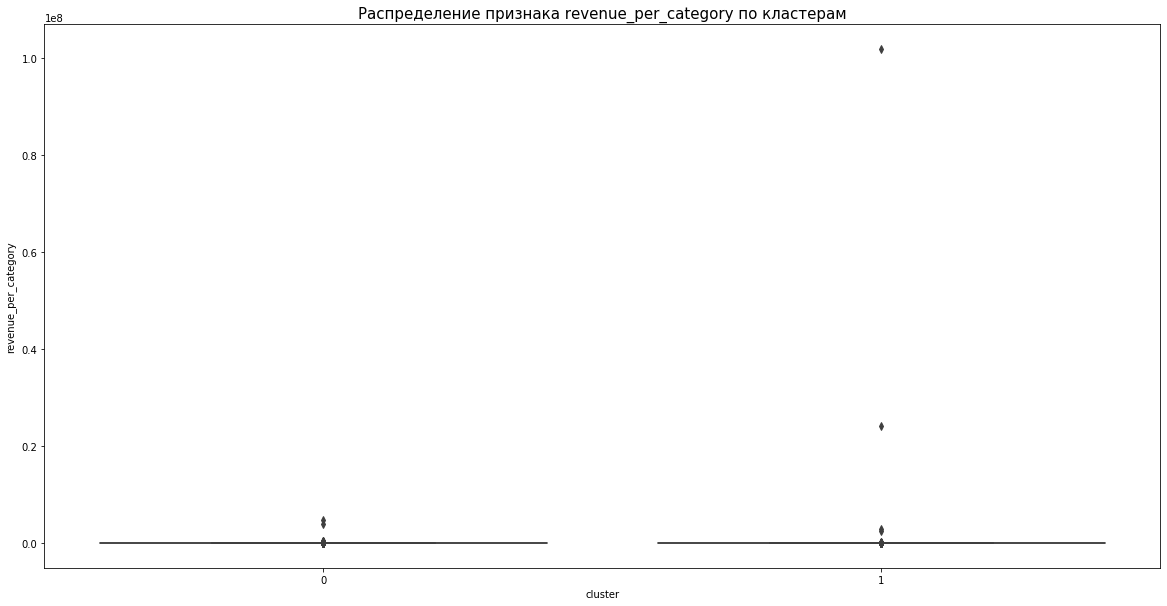

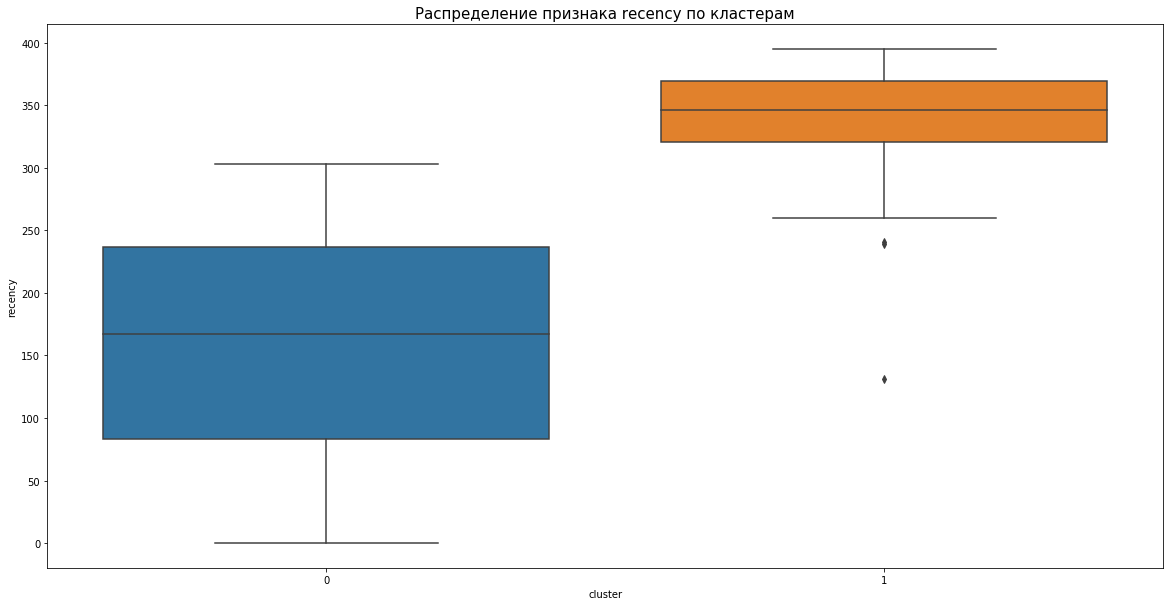

In [45]:
# Строим распределения для признаков

columns_categorical = ['year', 'month', 'favorite_category_numeric']

for column in columns_categorical:
    plt.figure(figsize = (20,10))
    plt.title('Распределение признака {} по кластерам'.format(column), fontsize = 15)
    sns.countplot(data = df_customer_id, x = column, hue = 'cluster')
    plt.show()


columns_continuous = ['product_quantity', 'total_quantity', 'avg_price', 'revenue_per_customer', 'avg_price_per_category',
                      'revenue_per_category', 'recency']

for column in columns_continuous:
    plt.figure(figsize = (20,10))
    plt.title('Распределение признака {} по кластерам'.format(column), fontsize = 15)
    sns.boxplot(x ='cluster', y = column, data = df_customer_id)
    plt.show()

# 4.1. Сегментация пользователей и проверка гипотез: выводы<a id="segmentation_end"></a>

**Кластер 0:**
- Среднее количество заказанных товаров в транзакции равно 1 
- Среднее количество всех купленных товаров равно 1
- Средняя цена товара равна 300 у.е.
- Потребители данного кластера совершали покупки и в 2018, и в 2019 году
- Потребители этого кластера совершали покупки больше всего в феврале, марте и апреле
- Средняя выручка на пользователя равна 727 у.е.
- Потребители из кластера 0 покупают продукты из всех категорий
- Потребители из кластера 0 покупают больше всего товаров категории растения
- В среднем давность последней транзакции равна 167 дням

**Рекомендация для кластера 0**
- Таргетированную рекламу лучше проводить в феврале-апреле, запускать ее на товары категории растения по цене около 300 рублей


**Кластер 1:**
- Среднее количество заказанных товаров в транзакции равно 1 
- Среднее количество всех купленных товаров равно 1
- Средняя цена товара равна 450 у.е.
- Потребители данного кластера совершали покупки в 2018 году
- Больше всего покупок потребители этого кластера совершали в октябре, ноябре и декабре
- Средняя выручка на пользователя равна 974 у.е.
- Потребители из кластера 1 покупают продукты из всех категорий
- Потребители из кластера 1 покупают больше всего товаров для дома
- В среднем давность последней транзакции равна 346 дням

**Рекомендация для кластера 1**
- Таргетированную рекламу лучше проводить в октябре, ноябре и декабре, запускать ее на товары для дома по цене около 450 рублей